In [1]:
from btypes import *
from copy import deepcopy
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Mapping, Set
from algorithm import draw_graph

In [2]:
def algorithm(G: Graph, u: Node, v:Node):
    v_node = G.nodes_obj[v]
    u_node = G.nodes_obj[u]
    v_neighbors = [
        Edge(
            from_node=x.label, 
            to_node=v_node.label,
            expected_delay=expected,
            worst_case_delay=worst
        ) for x, (expected, worst) in v_node.in_going.items() if x.label != u
    ] # technically, unnecessary. Might remove it in the future
    n = len(G.nodes_obj)
    u_node.clean(v_neighbors, v, v)
    for _ in range(n):
        v_node.propogate(v_neighbors, v, []) # passing v to propogate does nothing to v_node.

In [3]:
def test_algorithm(name: str, graph: Graph, destination: Node, edge: Tuple[Node, Node], change: Tuple[int, int]):
    old_tables = original_baruah(graph, destination, True)
    (u, v) = edge
    old_edges = deepcopy(graph.data)
    graph.modify_edge(u, v, change)
    algorithm(graph, u, v)
    new_tables = original_baruah(graph, destination, True)
    expected_changes = difference_tables(old_tables, new_tables)
    actual_tables = construct_tables(graph)
    actual_changes = difference_tables(old_tables, actual_tables)

    # print(f"--- {name} ---");
    # print()

    show_debug = False

    if actual_changes != expected_changes:
        print("FAIL")
        fail = difference_tables(new_tables, actual_tables)
        print_tables(fail)
        print(f"graph: {old_edges}")
        print(f"edge: {edge}")
        print(f"new weight: {change}")
        print("result: ")
        print_tables(actual_tables)
        print("expected: ")
        print_tables(new_tables)
        print("old tables: ")
        print_tables(old_tables)
        return 0
    return 1

In [4]:
def random_test(num_tests=1000, min_nodes=5, max_nodes=15, max_delay=20):
    passes = 0
    def random_delay():
        typical = random.randint(1, max_delay-1)
        return (typical, random.randint(typical + 1, max_delay))

    for i in range(1, num_tests + 1):
        nodes = [x for x in range(random.randint(min_nodes, max_nodes))] # create the nodes
        graph = dict((x, {y: random_delay()}) for x, y in zip(nodes, nodes[1:])) # turn the path into a dictionary
        n = len(nodes) # get the number of nodes
        biggest_node = n - 1
        graph[biggest_node] = {} # the last edge does not go anywhere afterwards

        for x in range(random.randint(0, n*(n-1))): # create a random number of edges. n(n-1) is the maximum number of edges
            from_node = random.randint(0, biggest_node)
            to_node = random.randint(0, biggest_node)
            while to_node == from_node: # makes sure that the to node and the from node are not the same
                to_node = random.randint(0, biggest_node)
            graph[from_node][to_node] = random_delay() # currently has an issue of accidentally overriding previous edges. But oh well.
            # graph[to_node].pop(from_node, None)
        g = Graph(graph)
        g.init_tables(biggest_node)
        from_node = random.randint(0,biggest_node) # select a random node
        while len(graph[from_node].keys()) == 0: # make sure that the node has out going edges. (might not always be the case that the node has outgoing edges)
            from_node = random.randint(0,biggest_node) # select a random node
        to_node = random.choice(list(graph[from_node].keys())) # select one of its edges
        edge = g.edge(from_node, to_node)
        new_delay = random.randint(1, edge.worst_case_delay)
        passes += test_algorithm(f"test {i}", g, biggest_node, (from_node, to_node), (new_delay, edge.worst_case_delay))
        print(f"{i - passes}/{i:,}", end="\r")
    return passes


# Does not work with single propogation

In [5]:
G = Graph({
    0: {1: (2, 18)},
    1: {0:(1, 8), 2: (3, 18)},
    2: {},
})
G.init_tables(2)
test_algorithm("test", G, 2, (1, 2), (11, 18))

1

# Does not work with clean function with v-neighbors trimming

In [8]:
G = Graph({
    0: {4: (10, 11), 3: (6, 14)}, 
    1: {2: (7, 14)}, 
    2: {1: (13, 18), 0: (5, 11)}, 
    3: {4: (2, 18), 0: (2, 6)}, # Note, adding an edge to 1 adds more errors everywere
    4: {}
})
G.init_tables(4)
test_algorithm("test", G, 4, (2, 3), (13, 14))

FAIL
0 removed: set(), added: set()
1 removed: set(), added: set()
2 removed: {Entry: 57 1 33}, added: {Entry: 56 1 33}
3 removed: set(), added: set()
4 removed: set(), added: set()
graph: {0: {4: (10, 11), 3: (6, 14)}, 1: {2: (7, 14)}, 2: {1: (13, 18), 0: (5, 11)}, 3: {4: (2, 18), 0: (2, 6)}, 4: {}}
edge: (2, 3)
new weight: (13, 14)
result: 
0 [Entry: 31 3 8, Entry: 11 4 10]
1 [Entry: 43 2 20, Entry: 36 2 22]
2 [Entry: 36 0 13, Entry: 22 0 15, Entry: 31 3 15, Entry: 56 1 33, Entry: 54 1 35]
3 [Entry: 18 4 2, Entry: 33 0 10, Entry: 17 0 12]
4 [Entry: 0 None 0]
expected: 
0 [Entry: 31 3 8, Entry: 11 4 10]
1 [Entry: 43 2 20, Entry: 36 2 22]
2 [Entry: 36 0 13, Entry: 57 1 33, Entry: 31 3 15, Entry: 22 0 15, Entry: 54 1 35]
3 [Entry: 18 4 2, Entry: 33 0 10, Entry: 17 0 12]
4 [Entry: 0 None 0]
old tables: 
0 [Entry: 31 3 8, Entry: 11 4 10]
1 [Entry: 43 2 20, Entry: 36 2 22]
2 [Entry: 36 0 13, Entry: 57 1 33, Entry: 22 0 15, Entry: 54 1 35]
3 [Entry: 18 4 2, Entry: 33 0 10, Entry: 17 0 12]
4

0

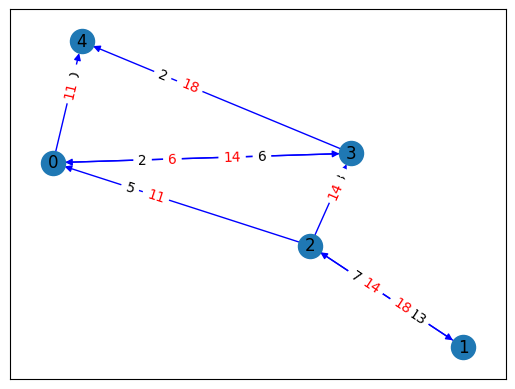

In [12]:
draw_graph(G)

In [106]:
G = Graph({
    0: {4: (10, 11), 3: (6, 14), 1:(13, 14)}, 
    1: {2: (7, 14)}, 
    2: {1: (13, 18), 0: (5, 11)}, 
    3: {4: (2, 18), 1: (12, 15), 0: (2, 6)}, 
    4: {}
})
G.init_tables(4)
test_algorithm("test", G, 4, (2, 3), (13, 14))

FAIL
0 removed: {Entry: 57 1 33}, added: {Entry: 56 1 33}
1 removed: set(), added: set()
2 removed: {Entry: 57 1 33}, added: {Entry: 56 1 33}
3 removed: {Entry: 56 1 32}, added: {Entry: 55 1 32}
4 removed: set(), added: set()
graph: {0: {4: (10, 11), 3: (6, 14), 1: (13, 14)}, 1: {2: (7, 14)}, 2: {1: (13, 18), 0: (5, 11)}, 3: {4: (2, 18), 1: (12, 15), 0: (2, 6)}, 4: {}}
edge: (2, 3)
new weight: (13, 14)
result: 
0 [Entry: 31 3 8, Entry: 11 4 10, Entry: 56 1 33, Entry: 50 1 35]
1 [Entry: 43 2 20, Entry: 36 2 22]
2 [Entry: 31 3 15, Entry: 36 0 13, Entry: 22 0 15, Entry: 56 1 33, Entry: 54 1 35]
3 [Entry: 18 4 2, Entry: 33 0 10, Entry: 17 0 12, Entry: 55 1 32, Entry: 51 1 34]
4 [Entry: 0 None 0]
expected: 
0 [Entry: 57 1 33, Entry: 31 3 8, Entry: 50 1 35, Entry: 11 4 10]
1 [Entry: 43 2 20, Entry: 36 2 22]
2 [Entry: 36 0 13, Entry: 57 1 33, Entry: 31 3 15, Entry: 22 0 15, Entry: 54 1 35]
3 [Entry: 18 4 2, Entry: 51 1 34, Entry: 33 0 10, Entry: 17 0 12, Entry: 56 1 32]
4 [Entry: 0 None 0]
ol

0

# Does not work with n - 1

In [12]:
G = Graph({
    0: {1:(19, 20)},
    1: {2:(1, 15), 0:(2, 19)},
    2: {3:(15, 16), 1:(11, 12)},
    3: {4:(5, 11), 2:(9, 14)},
    4: {3:(17, 18)}
})
G.init_tables(4)
test_algorithm("test", G, 4, (1, 0), (1, 19))

1

# Does not work with n propogations and no cleaning

In [21]:
G = Graph({
    0: {3:(18, 19), 2:(13, 14), 1:(19, 20)},
    1: {2:(1, 19)},
    2: {1:(1, 3), 3:(1, 20)},
    3: {4:(11, 20)},
    4: {2:(17, 19), 0:(6, 19)}
})
G.init_tables(4)
test_algorithm("test", G, 4, (2, 3), (20, 204))

1

In [26]:
num_tests = 1_000_000
result = random_test(num_tests=num_tests, min_nodes=3, max_nodes=3)
print(f"score: {result}/{num_tests}")

score: 1000000/1000000


# Does not work with v neighbor trimming and no cleaning

In [22]:
G = Graph({
    0: {1:(6, 16), 3:(1, 10)},
    1: {2:(17 ,20)},
    2: {3:(19, 20), 4:(10, 11)},
    3: {4:(2, 18), 0:(1, 13)},
    4: {}
})
G.init_tables(4)
test_algorithm("test", G, 4, (3, 4), (18, 18))

1

# Does not work with cleaning + single propogation

In [23]:
G = Graph({
    0: {1: (2, 19)},
    1: {2:(15, 18)},
    2: {0: (12, 16)},
})
G.init_tables(2)
test_algorithm("test", G, 2, (0, 1), (8, 19))

1

In [24]:
G = Graph({
    0: {1: (8, 14)}, 
    1: {2: (1, 4), 0: (15, 19)}, 
    2: {3: (15, 17)}, 
    3: {4: (11, 13), 0: (3, 13)}, 
    4: {0: (17, 19)}
})
G.init_tables(4)
test_algorithm("test", G, 4, (1, 2), (2, 4))

1